# Описание задания

В рамках данного задания, студент должен создать и оценить 4 типа рекомендательных систем:
* Non-personalized RS
* Content-based RS
* Item-based collaborative filtering RS
* Hybrid RS

Каждая рекомендательная система - отдельное подзадание. Подзадание считается выполненным, если студент создал рекомендательную систему, которая **лучше (или хуже, но не более чем на 10%)** системы, созданной автором данного блокнота. Системы оцениваются с использованием метрики ``HR@N``, описанной ниже.

# Детальное описание

#### Данные: 
Датасет представлен множеством отзывов к компьютерным играм (объектам) от пользователей Amazon. Каждый отзыв представлен в виде JSON-структуры со следующими полями:
* идентификатор пользователя - reviewerID
* идентификатор объекта - asin
* текст отзыва - reviewText
* рейтинг - overall
* время публикации обзора - unixReviewTime
* другие поля, не использованные автором этого блокнота (смотри полное описание JSON [тут](http://jmcauley.ucsd.edu/data/amazon/))

У каждого объекта есть как минимум 5 отзывов, каждый пользователь написал как минимум 5 отзывов. 
#### Цель: 
Построить рекомендательную систему, предсказывающую объекты, которые пользователь приобретет в ближайшем будущем. Для упрощения мы считаем, что пользователь приобрел объект, если он написал про него отзыв.
#### Подготовка данных:
Данные разделены на тренировочную и тестовую выборки по времени публикации отзывов. Первые 80% данных (более старые) используются как тренировочная выборка, остальные - как тестовая. 

Построение рекомендательной системы (т.е., выбор и тренировка моделей, оптимизация параметров и т.д.) осуществляется **только** с использованием тренировочной выборки. Все параметры, использованные в моделях, **должны быть** получены или объяснены с помощью тренировочных данных. Студент вправе использовать тренировочную выборку как его душе угодно. 

Тестирующая выборка используется **только** для оценки рекомендательной системы.

Для построения рекомендательных моделей также можно использовать JSON-поля из датасета, неиспользованные автором этого блокнота.
#### Оценка качества рекомендательной системы
Цель рекомендательной системы - посоветовать пользователю объекты, которые он захочет приобрести. Для оценки качества такой системы мы воспользуемся метрикой `hit-ratio (HR)`. 

$$
HR = \frac{1}{|U_T|}\sum_{u \in U_T} \mathrm{I}(Rel_u \cap Rec_u)
$$

* $U_T$ - множество пользователей из тестовой выборки
* $Rec_u$ - множество объектов, рекомендованных пользователю $u$ 
* $Rel_u$ - множество объектов, оцененных пользователем $u$ в тестовой выборке
* $\mathrm{I}(Rel_u \cap Rec_u)$ - бинарная функция-индикатор. Функция возвращает 1 если $Rel_u \cap Rec_u \ne \emptyset$, иначе 0

$HR=1$ если для каждого пользователя мы рекомендовали хотя бы один релевантный объект. Так как обычно пользователи просматривают только первые $N$ рекомендаций, мы будем считать метрику $HR@N$, где $N=10$ (т.е. множество $Rec_u$ будет содержать только 10 объектов). 

# Условные обозначения
* `uid` - идентификатор пользователя
* `iid` - идентификатор объекта

# Games RSs

In [1]:
# импорты, которые точно понадобятся
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.core.display import Image, display

In [2]:
# Данные взяты отсюда - http://jmcauley.ucsd.edu/data/amazon/
# http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz
JSON_DATA_PATH = "C:\\temp\\Video_Games_5.json"
N = 10

## Анализ данных

In [3]:
import json

def iter_json_data(path):
    with open(path) as f:
        for line in f:
            data = json.loads(line)
            yield data
            
def get_data_frame():
    uid_to_id = {}
    iid_to_id = {}
    
    cols = ["uid", "iid", "review", "rating", "dt"]
    rows = []
    for d in iter_json_data(JSON_DATA_PATH):
        uid = uid_to_id.setdefault(d["reviewerID"], len(uid_to_id))
        iid = iid_to_id.setdefault(d["asin"], len(iid_to_id))
        review = d["reviewText"]
        rating = float(d["overall"])
        dt = int(d["unixReviewTime"])
        rows.append((uid, iid, review, rating, dt))
    
    return pd.DataFrame(rows, columns=cols), uid_to_id, iid_to_id

In [4]:
df, uid_to_id, iid_to_id = get_data_frame()
df.head()


,uid,iid,review,rating,dt
0,0,0,Installing the game was a struggle (because of...,1.0,1341792000
1,1,0,If you like rally cars get this game you will ...,4.0,1372550400
2,2,0,1st shipment received a book instead of the ga...,1.0,1403913600
3,3,0,"I got this version instead of the PS3 version,...",3.0,1315958400
4,4,0,I had Dirt 2 on Xbox 360 and it was an okay ga...,4.0,1308009600


### Создадим словарь изображений и названий продуктов

In [5]:
def get_titles_frame(uid_to_id, iid_to_id):
    titles_csv = pd.read_csv('titles.csv')
    titles = {}
    
    for index, row in titles_csv.iterrows():
        if row["asin"] in iid_to_id:
            titles[iid_to_id[row["asin"]]] = { "title":row["title"], "imUrl":row["imUrl"]}
    return titles

In [6]:
titles = get_titles_frame(uid_to_id, iid_to_id)

In [7]:
print("min-max количество объектов на пользователя:", 
      df.groupby("uid").iid.nunique().min(), df.groupby("uid").iid.nunique().max())
print("min-max количество пользователей на объект:", 
      df.groupby("iid").uid.nunique().min(), df.groupby("iid").uid.nunique().max())

min-max количество объектов на пользователя: 5 773
min-max количество пользователей на объект: 5 802


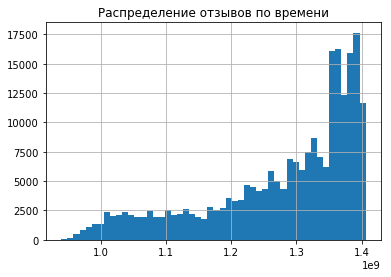

In [8]:
plt.title("Распределение отзывов по времени")
df.dt.hist(bins=50)

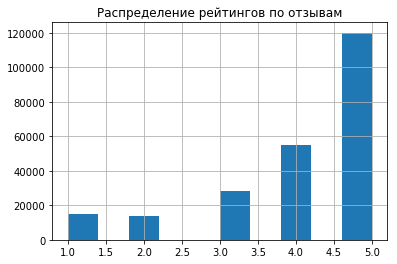

In [9]:
plt.title("Распределение рейтингов по отзывам")
df.rating.hist()

In [10]:
# проверяем, есть ли случаи, когда один и тот же пользователь оставляет отзывы на один и тот же объект
Uid_iid_pair = df.groupby(["uid", "iid"]).review.count().unique()  # ура, таких случаев нет
for uip in Uid_iid_pair:
    print(uip, " ")

1  


In [11]:
print("Количество объектов:", df.iid.unique().size)
print("Количество пользователей:", df.uid.unique().size)

Количество объектов: 10672
Количество пользователей: 24303


## Готовим выборки

In [12]:
def split_df_by_dt(df, p=0.8):
    """Функция разбивает df на тестовую и тренировочную выборки по времени 
    публикации отзывов (значение времени в поле dt)
    
    :param p: персентиль значений dt, которые образуют тренировочную выборку. Например p=0.8 означает, что в 
    тренировочной части будут отзывы, соответствующие первым 80% временного интервала 
    :return: два pd.DataFrame объекта
    """
    border_dt = df.dt.quantile(p)
    print("Min=%s, border=%s, max=%s" % (df.dt.min(), border_dt, df.dt.max()))
    training_df, test_df  = df[df.dt <= border_dt], df[df.dt > border_dt]
    print("Размер до очистки:", training_df.shape, test_df.shape)
    # удаляем из тестовых данных строки, соответствующие пользователям или объектам, 
    # которых нет в тренировочных данных 
    # (пользователи - избегаем проблем для персональных систем, объекты - для всех)
    test_df = test_df[test_df.uid.isin(training_df.uid) & test_df.iid.isin(training_df.iid)]
    print("Размер после очистки:", training_df.shape, test_df.shape)
    return training_df, test_df

In [13]:
training_df, test_df = split_df_by_dt(df)
del df

Min=939859200, border=1377129600.0, max=1405987200
Размер до очистки: (185427, 5) (46353, 5)
Размер после очистки: (185427, 5) (19174, 5)


Удалим отзывы на игры у которых меньше  5 отзывов

In [ ]:
training_df

In [14]:

training_df.head()

,uid,iid,review,rating,dt
0,0,0,Installing the game was a struggle (because of...,1.0,1341792000
1,1,0,If you like rally cars get this game you will ...,4.0,1372550400
3,3,0,"I got this version instead of the PS3 version,...",3.0,1315958400
4,4,0,I had Dirt 2 on Xbox 360 and it was an okay ga...,4.0,1308009600
5,5,0,"Overall this is a well done racing game, with ...",4.0,1368230400


In [15]:
def clean_df(df, min_review_per_uid, min_review_per_iid):
    """Функция удаляет из df строки, соответствующие пользователям и объектам, 
    у которых меньше min_review_per_uid и min_review_per_iid отзывов соответственно
    """
    _df = df.copy()
    while True:
        review_per_uid = _df.groupby("uid").review.count()
        bad_uids = review_per_uid[review_per_uid < min_review_per_uid].index
    
        review_per_iid = _df.groupby("iid").review.count()
        bad_iids = review_per_iid[review_per_iid < min_review_per_iid].index
        
        if bad_uids.shape[0] > 0 or bad_iids.shape[0] > 0:
            _df = _df[(~_df.uid.isin(bad_uids)) & (~_df.iid.isin(bad_iids))]
        else:
            break
    return _df

 ## Метрика

Для упрощения тестирования предлагается использовать словарь следующего типа:

```python
recs = {
    uid_1: {
        iid_1: score_11,
        iid_2: score_12,
        ...
    },
    uid_2: {
        iid_1: score_21,
        iid_2: score_22,
        ...
    },
    ...
}
```

где `uid_i` - идентификатор тестового пользователя, `iid_j` - идентификатор рекомендованного объекта, а `score_ij` - предсказанный рейтинг/вес объекта `j` для пользователя `i`.

In [16]:
def hit_ratio(recs_dict, test_dict):
    """Функция считает метрику hit-ration для двух словарей
    :recs_dict: словарь рекомендаций типа {uid: {iid: score, ...}, ...}
    :test_dict: тестовый словарь типа {uid: {iid: score, ...}, ...}
    """
    hits = 0
    for uid in test_dict:
        if set(test_dict[uid].keys()).intersection(recs_dict.get(uid, {})):
            hits += 1
    return hits / len(test_dict)

In [17]:
def get_test_dict(test_df):
    """Функция, конвертирующая тестовый df в словарь
    """
    test_dict = {}
    for t in test_df.itertuples():
        test_dict.setdefault(t.uid, {})
        test_dict[t.uid][t.iid] = t.rating
    return test_dict

test_dict = get_test_dict(test_df)
training_dict = get_test_dict(training_df)

## Non-personalized RS

В первом подзадании студент должен построить неперсонализированную рекомендательную систему. Т.е. рекомендации для одного пользователя строятся на основе отзывов, оставленных всеми пользователями.

### Найдем самые популярные игры

In [18]:
rating_per_user = training_df.uid.value_counts()
rating_per_user.min(), rating_per_user.max()

(1, 773)

In [19]:
rating_per_game = training_df.iid.value_counts()
rating_per_game.min(), rating_per_game.max()

(1, 471)

In [20]:
rating1 = rating_per_game

In [21]:
rating1.head(10)

5390    471
3323    429
8659    361
5489    350
3536    349
1341    348
8151    329
4939    313
9402    313
3851    312
Name: iid, dtype: int64

In [22]:
def show_game_list(rating):
    for index, score in rating.iteritems():
        print(index, " - ",titles[index]['title'], " ", titles[index]['imUrl'], ":", score)
        display(Image(url=titles[index]['imUrl']))

In [23]:
show_game_list(rating1.head(5))

5390  -  No title   http://ecx.images-amazon.com/images/I/41E1q8ukJRL._SX300_.jpg : 471


3323  -  Wii   http://ecx.images-amazon.com/images/I/41xM31QiwdL._SX300_.jpg : 429


8659  -  No title   http://ecx.images-amazon.com/images/I/51KA8qJIlCL._SY300_.jpg : 361


5489  -  No title   http://ecx.images-amazon.com/images/I/41kXCp%2BUyeL._SY300_.jpg : 350


3536  -  No title   http://ecx.images-amazon.com/images/I/41Io17jh4IL._SY300_.jpg : 349


### Определяем функцию для генирации словаря из списка, выданного неперсонализированной системой

In [24]:
def get_NonPers_dict(training_dict, test_dict, best_list):
    NonPers_dict = {}
    for uid in test_dict.keys():
        NonPers_dict.setdefault(uid, {})
        i = 0
        NonPers_dict[uid] = []
        while len(NonPers_dict[uid]) < 10:
            if best_list.index[i] not in training_dict[uid].keys():
                NonPers_dict[uid].append(best_list.index[i])
            i +=1
    return NonPers_dict

In [25]:
print("HR@10: ", hit_ratio( get_NonPers_dict(training_dict, test_dict, rating1), test_dict) )

HR@10:  0.04005869405722671


### Видно что в выборке задейсвованы действительно в реальности довольно популярные игры и товары, тоесть в целом она корректра. 
### Но результат недостаточен чтобы сдать лабу :(
### Попробуем учитывать рейтинг игры. Логичнее штрафовать за плохой рейтинг и поощерять за хороший а нейтральные игнорировать
### Для нормировки просто вычтим средний балл 3

In [26]:
rating2 = rating1.copy().apply(lambda i: 0) 
for index, row in training_df.iterrows():
    rating2.set_value(value=rating2[row.iid] + row.rating - 3, label=row.iid)
rating2.sort_values(ascending=False, inplace=True)
rating2.head()

5390    753
3536    641
3323    624
1341    537
6053    524
Name: iid, dtype: int64

In [27]:
show_game_list(rating2.head(5))

5390  -  No title   http://ecx.images-amazon.com/images/I/41E1q8ukJRL._SX300_.jpg : 753


3536  -  No title   http://ecx.images-amazon.com/images/I/41Io17jh4IL._SY300_.jpg : 641


3323  -  Wii   http://ecx.images-amazon.com/images/I/41xM31QiwdL._SX300_.jpg : 624


1341  -  No title   http://ecx.images-amazon.com/images/I/51YQRBW6N7L._SY300_.jpg : 537


6053  -  No title   http://ecx.images-amazon.com/images/I/61qAVZayaZL._SY300_.jpg : 524


### Девайсы остались, игры сменились. Пока не понятно лучше это или хуже. 
### По хорошему бы выкинуть девайсы и подарочные талоны. Но это не входит в задание :)
### Посмотрим, что получилось теперь

In [28]:
print("HR@10: ", hit_ratio( get_NonPers_dict( training_dict, test_dict, rating2), test_dict) )

HR@10:  0.08011738811445342


### А ларчик просто открывался :)

###  Видно что в топе довольно старые игры, попробуем  штрафовать старые комментарии, т. к. они мение актуальны.

In [29]:
max_dt = training_df.dt.max()
rating3 = rating1.copy().apply(lambda i: 0) 
for index, row in training_df.iterrows():
    rating3.set_value(value=(rating3[row.iid] + row.rating - 3)* 0.99**((max_dt-row["dt"])/(60*60*24*365)),label=row.iid)
 
rating3.sort_values(ascending=False, inplace=True)
rating3.head()

9267    180
8659    121
7163    116
3536    109
8401    105
Name: iid, dtype: int64

In [30]:
show_game_list(rating3.head(5))

9267  -  No title   http://ecx.images-amazon.com/images/I/61WVjDOzNEL._SY300_.jpg : 180


8659  -  No title   http://ecx.images-amazon.com/images/I/51KA8qJIlCL._SY300_.jpg : 121


7163  -  No title   http://ecx.images-amazon.com/images/I/415TMngowzL._SY300_.jpg : 116


3536  -  No title   http://ecx.images-amazon.com/images/I/41Io17jh4IL._SY300_.jpg : 109


8401  -  No title   http://ecx.images-amazon.com/images/I/51kH-voitsL._SY300_.jpg : 105


### Отлично, в топе только новинки

In [31]:
print("HR@10: ", hit_ratio( get_NonPers_dict( training_dict, test_dict, rating3), test_dict) )

HR@10:  0.09405722670579604


#### `HR@10` для non-personalized модели, созданной автором блокнота: 0.055

### Подсказки
Подумайте, какие игры обычно приобретают люди. 
* Какие свойства, помимо, популярности могут помочь покупателю выбрать игру, если у него нет явных предпочтений? 
* Можно ли как-нибудь использовать рейтинги или время публикации отзывов?

## Content-based RS

Простая content-based рекомендательная система описывает пользователей и объекты как вектора в некотором N-мерном пространстве фич. Вектор объекта показывает, насколько объект принадлежит к той или иной фиче. Вектор пользователя показывает, насколько пользователь предпочитает ту или иную фичу. Рекомендации строятся путем поиска объектов, чьи вектора похожи на вектор предпочтений пользователя. Предполагается, что чем более похожи вектора пользователя и объекта, тем интереснее этот объект пользователю.

In [32]:
# посчитаем количество рейтингов на пользователя
r_per_user = training_df.uid.value_counts()
r_per_user.head()

970    773
164    634
500    443
300    414
851    382
Name: uid, dtype: int64

### Создадим toy-dataset

In [33]:
# посчитаем количество рейтингов на пользователя
r_per_user = training_df.uid.value_counts()
# оставим только 10 пользователей с 50 рейтингами
good_uids = np.random.choice(r_per_user[r_per_user > 50].index, size=10, replace=False)
good_uids

array([4491, 3152, 7853,  627, 6392, 1730, 3320, 1951,  389, 5824], dtype=int64)

In [34]:
training_df.shape

(185427, 5)

In [35]:
training_df10 = training_df[training_df.uid.isin(good_uids)]
training_df10.shape

(827, 5)

In [36]:
training_df10.head()

,uid,iid,review,rating,dt
437,389,35,Golden Eye 007 is still one of the best action...,5.0,1197417600
524,389,37,The very first Grand Theft Auto is likely the ...,3.0,1195776000
535,389,38,This was the first real game I ever played alo...,5.0,1195689600
748,627,40,"This is still a great game to own, especialy i...",4.0,1048464000
1009,389,53,I'm very reluctant to try the new Spyro game f...,4.0,1205625600


### Посчитаем TFIDF

In [37]:
training_df10.iid.unique().size

776

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf10 = TfidfVectorizer(stop_words='english')
tfidf10.fit(training_df10["review"].values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [61]:
from IPython.display import clear_output

In [108]:
def get_vectorCB(df, tfidf):
        vector = df["review"].copy()
        vector.name = "vector"
        p = "0%"
        v_max = vector.size
        v_count = 0
        for index, review in vector.iteritems():
            vector[index] = tfidf.transform([review])
            v_count += 1
            pnew = "{:10.0f}".format(v_count*100/v_max) + "%"
            if p != pnew:
                p = pnew
                clear_output()
                print(p)
        print("vector len = ", len(vector))
        return vector
                

In [110]:
vector10 = get_vectorCB( training_df10, tfidf10)
vector10.head()

       100%
vector len =  827


437       (0, 10204)\t0.0989923085771\n  (0, 9973)\t0....
524       (0, 10135)\t0.128325280998\n  (0, 9503)\t0.1...
535       (0, 10218)\t0.206911785914\n  (0, 9973)\t0.0...
748       (0, 9960)\t0.214722615681\n  (0, 5751)\t0.40...
1009      (0, 10202)\t0.0545074229995\n  (0, 10177)\t0...
Name: vector, dtype: object

### Создадим профиль первого объекта

In [111]:
target_g = training_df10.iid.values[0]
target_g

35

In [112]:
vector10.values[0]

<1x10253 sparse matrix of type '<class 'numpy.float64'>'
	with 47 stored elements in Compressed Sparse Row format>

In [113]:
item_profile = vector10.values[0].copy() * 0
for index, row in training_df10.iterrows():
    if row.iid == target_g:
        item_profile += vector10[index]
item_profile.data

array([ 0.1864852 ,  0.12162537,  0.16330447,  0.11894065,  0.1864852 ,
        0.07343538,  0.20165331,  0.16261829,  0.1864852 ,  0.18012053,
        0.11496671,  0.13449147,  0.14988665,  0.16562318,  0.10028268,
        0.14988665,  0.11980744,  0.06709992,  0.1555392 ,  0.1864852 ,
        0.13601445,  0.17838169,  0.19790645,  0.11148472,  0.16696045,
        0.19790645,  0.15885694,  0.04782943,  0.08328903,  0.11728322,
        0.13601445,  0.13933219,  0.09435144,  0.13933219,  0.12162537,
        0.11809975,  0.17209613,  0.09581506,  0.12910977,  0.14115013,
        0.23619949,  0.15885694,  0.11352187,  0.12162537,  0.17838169,
        0.07554899,  0.09899231])

In [114]:
ftr_id_to_term = {ftr_id: term for term, ftr_id in tfidf10.vocabulary_.items()}
for ftr_id, score in sorted(zip(item_profile.indices, item_profile.data), key=lambda x: x[1], reverse=True):
    print(ftr_id_to_term[ftr_id], ":", score)

superb : 0.236199492192
best : 0.201653308569
intellignce : 0.197906447513
layouts : 0.197906447513
007 : 0.186485199309
artificial : 0.186485199309
competitors : 0.186485199309
handed : 0.186485199309
cool : 0.180120531863
intelligent : 0.178381694746
virtually : 0.178381694746
rights : 0.172096128285
james : 0.166960446542
enemies : 0.165623176164
action : 0.163304473261
bond : 0.162618289499
licensed : 0.15885694198
targeting : 0.15885694198
golden : 0.155539198338
ea : 0.149886653213
executed : 0.149886653213
smart : 0.141150127315
polished : 0.139332189214
product : 0.139332189214
incredibly : 0.136014445572
odd : 0.136014445572
created : 0.13449146581
shooters : 0.129109771464
10 : 0.121625374549
release : 0.121625374549
unfortunately : 0.121625374549
eye : 0.119807436448
ago : 0.118940652243
released : 0.118099746096
nintendo : 0.117283217505
couple : 0.114966713044
titles : 0.113521869986
issues : 0.111484722499
excellent : 0.100282683681
years : 0.0989923085771
save : 0.095815

In [134]:
def get_gamesCB(df, vector):
    games = df.iid.value_counts().apply(lambda i:0 )
    
    p = "0%"
    v_max = vector.size
    v_count = 0
    for index, row in df.iterrows():
        games[row.iid] = games[row.iid] + vector[index]
        
        v_count += 1
        pnew = "{:10.0f}".format(v_count*100/v_max) + "%"
        if p != pnew:
            p = pnew
            clear_output()
            print(p)
    return games;

In [116]:
games10 = get_gamesCB(training_df10, vector10)
games10.head()

1341      (0, 86)\t0.254453834619\n  (0, 657)\t0.17654...
1270      (0, 1948)\t0.358049659792\n  (0, 3085)\t0.25...
7299      (0, 121)\t0.0619723927265\n  (0, 180)\t0.061...
1478      (0, 1222)\t0.227047916561\n  (0, 1544)\t0.34...
3768      (0, 12)\t0.0877602999751\n  (0, 131)\t0.0719...
Name: iid, dtype: object

In [117]:
from scipy.sparse import vstack

print( len(games10))
games10_stack = vstack(games10, 'csr')
games10_stack

776


<776x10253 sparse matrix of type '<class 'numpy.float64'>'
	with 61700 stored elements in Compressed Sparse Row format>

###  Создадим профиль пользователя

In [138]:
def get_usersCB(df, vector):
    
    users_mean = df.uid.value_counts().copy().apply(lambda i: 0.0)
    for uid, value in users_mean.iteritems():
        uid_df = df[df.uid == uid]
        users_mean[uid] = uid_df.rating.mean()
    
    users = df.uid.value_counts().copy().apply(lambda i: vector.values[0].copy() * 0) 
    
    p = "0%"
    u_max = vector.size
    u_count = 0
    for index, row in df.iterrows():
        #if row.rating >= users_mean[row.uid]:
        users[row.uid] += vector[index] * row.rating
        
        u_count += 1
        pnew = "{:10.0f}".format(u_count*100/u_max) + "%"
        if p != pnew:
            p = pnew
            clear_output()
            print(p)
    return users;

In [119]:
uid = good_uids[0]
uid

4491

In [120]:
user_profile = get_usersCB(training_df10, vector10)[uid]
user_profile

<1x10253 sparse matrix of type '<class 'numpy.float64'>'
	with 3764 stored elements in Compressed Sparse Row format>

### CBRS

In [121]:
from sklearn.metrics.pairwise import cosine_similarity

In [122]:
sims = cosine_similarity(user_profile, games10_stack)

In [123]:
best_iid = np.argsort(sims[0])[-1]
best_iid, sims[0, best_iid]

(645, 0.45804043575885733)

In [124]:
len( np.argsort(sims[0]))

776

In [125]:
len( games10)

776

In [126]:
rating4_toy = games10.copy().apply(lambda i: 0.0) 
i = 0
for index, val in rating4_toy.iteritems():
    rating4_toy.set_value(value=sims[0, i],label=index)
    i += 1
rating4_toy.sort_values(ascending=False, inplace=True)
rating4_toy.head()

7669    0.458040
2686    0.436818
4928    0.420170
4500    0.419472
7299    0.404925
Name: iid, dtype: float64

In [127]:
show_game_list(rating4_toy.head(5))

7669  -  No title   http://ecx.images-amazon.com/images/I/5158xG4VDhL._SY300_.jpg : 0.458040435759


2686  -  No title   http://ecx.images-amazon.com/images/I/517FWVGH09L._SY300_.jpg : 0.43681754368


4928  -  No title   http://ecx.images-amazon.com/images/I/513v3n6t-CL._SY300_.jpg : 0.420169784753


4500  -  No title   http://ecx.images-amazon.com/images/I/5131NnRzVUL._SY300_.jpg : 0.419471506469


7299  -  No title   http://ecx.images-amazon.com/images/I/51rWhiddjrL._SY300_.jpg : 0.404924886135


### Видно, что в что все игры, это топовые 3D экшены на PS3 (когда обновил стали все мультяшки), можно предположить, 
### что это любимая тематика пользователя, 
### а значит алгоритм работает верно

# Начнем обработку основных данных
### Посчитаем TFIDF

In [128]:
training_df.iid.unique().size

10098

In [129]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfCB = TfidfVectorizer(stop_words='english')
tfidfCB.fit(training_df["review"].values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [130]:
vectorCB = get_vectorCB( training_df, tfidfCB)
vectorCB.head()

       100%
vector len =  185427


0      (0, 194467)\t0.128044007145\n  (0, 192400)\t...
1      (0, 193657)\t0.100352834254\n  (0, 188225)\t...
3      (0, 195580)\t0.0602709028671\n  (0, 195058)\...
4      (0, 194691)\t0.145504914003\n  (0, 165336)\t...
5      (0, 193563)\t0.0779779805105\n  (0, 192400)\...
Name: vector, dtype: object

### Создадим профили объектов

In [135]:
gamesCB = get_gamesCB(training_df, vectorCB)
gamesCB.head()

       100%


5390      (0, 158092)\t0.232501133595\n  (0, 31808)\t0...
3323      (0, 22252)\t0.287229229238\n  (0, 82504)\t0....
8659      (0, 135785)\t0.285785286968\n  (0, 169622)\t...
5489      (0, 59049)\t0.20652948654\n  (0, 158200)\t0....
3536      (0, 68153)\t0.195407525347\n  (0, 110085)\t0...
Name: iid, dtype: object

### Создадим профили пользователей

In [139]:
usersCB = get_usersCB(training_df, vectorCB)
len(usersCB)
usersCB.head()

       100%


970      (0, 25215)\t0.350263500113\n  (0, 41156)\t0....
164      (0, 36643)\t0.290775440022\n  (0, 39931)\t0....
500      (0, 17395)\t0.637730937451\n  (0, 30140)\t0....
300      (0, 23869)\t0.627982356586\n  (0, 47072)\t0....
851      (0, 19021)\t0.694711260447\n  (0, 49052)\t0....
Name: uid, dtype: object

### CBRS

In [140]:
usersCB_opt = usersCB.copy()
for uid, user_profileCB in usersCB_opt.iteritems():
    if uid not in test_dict.keys():
        usersCB_opt.drop(uid, inplace=True)

In [141]:
len( usersCB)

22215

In [142]:
len( usersCB_opt)

6815

In [143]:
len( test_dict)

6815

In [144]:
from sklearn.preprocessing import normalize

In [145]:
usersCB_opt2 = usersCB_opt.copy()
usersCB_opt2 = normalize(vstack(usersCB_opt2, 'csr'))
usersCB_opt2


<6815x197239 sparse matrix of type '<class 'numpy.float64'>'
	with 2137763 stored elements in Compressed Sparse Row format>

In [147]:
gamesCB_opt = gamesCB.copy()
gamesCB_opt = normalize(vstack(gamesCB_opt, 'csr'))
gamesCB_opt

<10098x197239 sparse matrix of type '<class 'numpy.float64'>'
	with 7356087 stored elements in Compressed Sparse Row format>

In [148]:
sims2 = cosine_similarity(usersCB_opt2, gamesCB_opt)
sims2

array([[ 0.20127015,  0.60628272,  0.18159636, ...,  0.02085501,
         0.07061549,  0.10860025],
       [ 0.25776217,  0.34999867,  0.40172279, ...,  0.06285186,
         0.21947675,  0.08567325],
       [ 0.22397932,  0.4103646 ,  0.32926869, ...,  0.05612559,
         0.17738865,  0.08880189],
       ..., 
       [ 0.05377081,  0.05589305,  0.06411035, ...,  0.        ,
         0.02540792,  0.        ],
       [ 0.09887812,  0.11046085,  0.12540813, ...,  0.03214622,
         0.06042476,  0.02832676],
       [ 0.05249458,  0.05825546,  0.06394585, ...,  0.0152028 ,
         0.02793667,  0.01321599]])

In [149]:
ResultCB2 = {}
u_count = 0 
u_max = len(usersCB_opt)
p = "0%"

empty_iid_series = gamesCB.copy().apply(lambda i: 0.0)
uid_rating = empty_iid_series.copy()
for uid, user_profileCB in usersCB_opt.iteritems():
    
    i = 0
    for index, val in empty_iid_series.iteritems():
        uid_rating.set_value(value=sims2[u_count, i],label=index)
        i += 1
    uid_rating.sort_values(ascending=False, inplace=True)
    
    ResultCB2.setdefault(uid, {})
    i = 0
    ResultCB2[uid] = []
    while len(ResultCB2[uid]) < 10:
        if uid_rating.index[i] not in training_dict[uid].keys():
            ResultCB2[uid].append(uid_rating.index[i])
        i +=1
    u_count += 1
    pnew = "{:10.0f}".format(u_count*100/u_max) + "%"
    if pnew != p:
        p = pnew
        clear_output()
        print(p)

       100%


### Оценка данных

In [150]:
print("HR@10: ", hit_ratio( ResultCB2, test_dict) )

HR@10:  0.05942773294203962


#### `HR@10` для content-based, модели созданной автором блокнота: 0.065

## Item-based collaborative filtering RS

Item-based CF основан на идее, что пользователь предпочтет объекты, похожие на те, что он приобретал ранее. Данные в CF модели представлены матрицей `user x item`, где ячейка матрицы соответствует рейтингу, который пользователь поставил объекту. Вместо рейтингов в матрице могут быть вероятности (т.е. вероятность, что пользователь воспользуется объектом). Для работы модели необходимо построить матрицу `item x item` схожести объектов. Обычно для построения матрицы схожести используется исходная матрица `user x item`. Чтобы уменьшить шумы в матрице схожести, для каждого объекта хранят только $K$ наиболее похожих объектов.

В простейшем случае рекомендации строятся путем нахождения объектов с наибольшим значением предсказанного рейтинга:
$$\hat{r}_{ui} = \frac{\sum_{j \in I_u} r_{uj} * sim(j, i)}{\sum_{j \in I_u} r_{uj}}$$

* $I_u$ - множество объектов, оцененных пользователем
* $sim(j, i)$ - схожесть между объектами $j$ и $i$

Часто из финальных рекомендаций для пользователя $u$ исключаются объекты $I_u$.

In [39]:
def load_data(df):
    rows = []
    cols = []
    data = []
    
    uid_to_row = {}
    iid_to_col = {}
    
    for t in df.itertuples():
        row_id = uid_to_row.setdefault(t.uid, len(uid_to_row))
        col_id = iid_to_col.setdefault(t.iid, len(iid_to_col))
        rating = t.rating
        
        rows.append(row_id)
        cols.append(col_id)
        data.append(rating)
        
    ui_m = csr_matrix((data, (rows, cols)))
    return ui_m, uid_to_row, iid_to_col

In [40]:
ui_m, uid_to_row, iid_to_col = load_data(training_df)

In [41]:
print("Density", ui_m.nnz / (ui_m.shape[0] * ui_m.shape[1]))
print("Max rating", ui_m.data.max())
print("Min rating", ui_m.data.min())
print("Shape", ui_m.shape)

Density 0.0008265921718676217
Max rating 5.0
Min rating 1.0
Shape (22215, 10098)


In [42]:
from sklearn.metrics.pairwise import cosine_similarity
ii_sim_m = cosine_similarity(ui_m.T.tocsr(), dense_output=False)

In [43]:
print("Density", ii_sim_m.nnz / (ii_sim_m.shape[0] * ii_sim_m.shape[1]))
print("Max sim", ii_sim_m.data.max())
print("Min sim", ii_sim_m.data.min())
print("Shape", ii_sim_m.shape)

Density 0.038468718580097656
Max sim 1.0
Min sim 0.000180093435822
Shape (10098, 10098)


In [44]:
# вспомогательные функции, которые могут пригодиться при построении Item-based CF
def nullify_main_diagonal(m):
    positions = range(m.shape[0])
    eye = csr_matrix((np.ones(len(positions)), (positions, positions)), m.shape)
    return m - m.multiply(eye)


def get_topk(matrix, top, axis=1):
    """Converts source matrix to Top-K matrix
    where each row or column contains only top K values

    :param matrix: source matrix
    :param top: number of top items to be stored
    :param axis: 0 - top by column, 1 - top by row
    :return:
    """
    rows = []
    cols = []
    data = []

    if axis == 0:
        matrix = matrix.T.tocsr()

    for row_id, row in enumerate(matrix):
        if top is not None and row.nnz > top:
            top_args = np.argsort(row.data)[-top:]

            rows += [row_id] * top
            cols += row.indices[top_args].tolist()
            data += row.data[top_args].tolist()
        elif row.nnz > 0:
            rows += [row_id] * row.nnz
            cols += row.indices.tolist()
            data += row.data.tolist()

    topk_m = csr_matrix((data, (rows, cols)), (matrix.shape[0], matrix.shape[1]))

    if axis == 0:
        topk_m = topk_m.T.tocsr()

    return topk_m

In [45]:
ii_sim_m = nullify_main_diagonal(ii_sim_m)
ii_sim_m = get_topk(ii_sim_m, top=30)

In [46]:
print("Density", ii_sim_m.nnz / (ii_sim_m.shape[0] * ii_sim_m.shape[1]))
print("Max sim", ii_sim_m.data.max())
print("Min sim", ii_sim_m.data.min())
print("Shape", ii_sim_m.shape)

Density 0.0029141527312393995
Max sim 1.0
Min sim 0.00140492678148
Shape (10098, 10098)


Item-based rating prediction

In [ ]:
from sklearn.preprocessing import binarize

user_id = 5317
item_id = 5390

up = ii_sim_m[item_id].dot(ui_m[user_id].T)
down = np.abs(ii_sim_m[item_id]).dot(binarize(ui_m[user_id]).T)

print(user_id, item_id, ":", ui_m[user_id, item_id])
print("Prediction:", up.sum() / down.sum())

#### `HR@10` для item-based CF модели, созданной автором блокнота: 0.085

### Подcказки
* Определитесь с тем, что вы пытаетесь предсказать (рейтинги, вероятности, ...)
* Оптимальный способ вычисления матрицы схожести выглядит так:
 * Привести строки в матрице `user x item` к единичной длине (выделяет основные предпочтения пользователя)
 * Построить матрицу схожести `item x item`
 * Для каждого объекта оставить только $K$ наиболее похожих объектов
 * Для каждого объекта привести к единичной длине вектор схожести этого объекта (выделяет наиболее схожие объекты)
* Удалили ли вы из рекомендаций объекты, которые пользователь уже оценивал?
* Статья "Item-Based Top-N Recommendation Algorithms", Mukund Deshpande и George Karypis

## Hybrid RS

Гибридная рекомендательная система - это объединение нескольких рекомендательных систем (мы не будем перечислять тут возможные способы гибридизации). Цель гибридизации - воспользоваться сильными сторонами нескольких моделей, чтобы улучшить качество рекомендаций.

В данном задании студент должен создать гибридную систему, состояющую **как минимум** из двух подсистем.

#### `HR@10` для гибридной модели, созданной автором блокнота: 0.096

### Подcказки
* Определите сильные и слабые стороны различных моделей
* Какие из них коррелируют? А какие могут дополнять друг друга?
* Только конечный результат работы системы должен содержать $N$ рекомендаций (промежуточные могут содержать больше)

## P.S.
В коде возможны пасхальные яйца ]:->, если у вас возникли вопросы, не стесняйтесь их задавать.